In [1]:
import sys
sys.path.append('../../Scripts')
from PostProcessingScripts import * 
import pandas as pd 
import string 
# just to make the cells appear wider:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# adjust fontsize 
fs=20
import ClassMSSFR
# from matplotlib.ticker import (FormatStrFormatter,
#                                AutoMinorLocator)

# Plot Figure C1 

warning no normalisation of mass evolved assuming 1


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log10


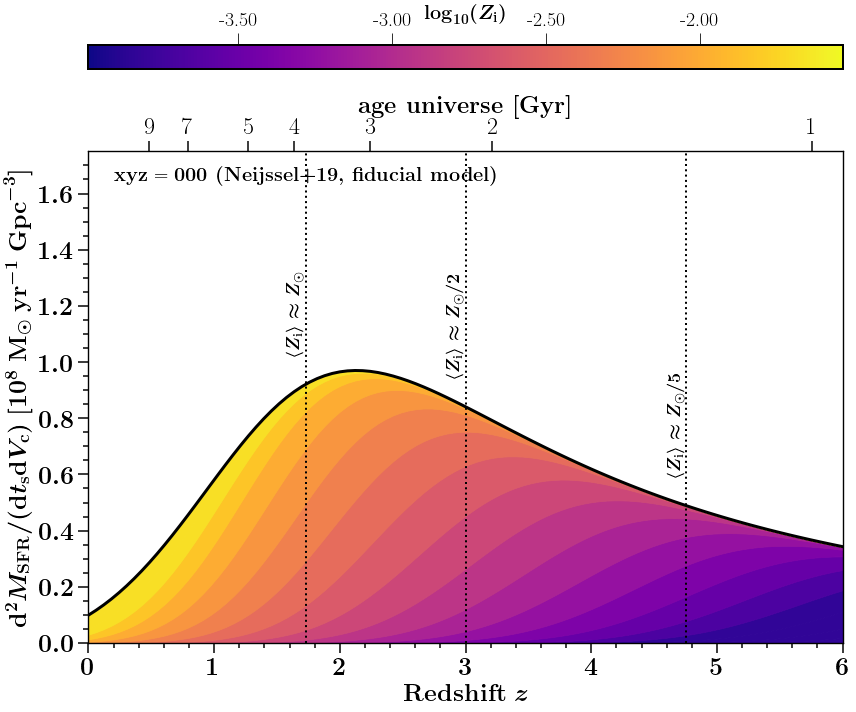

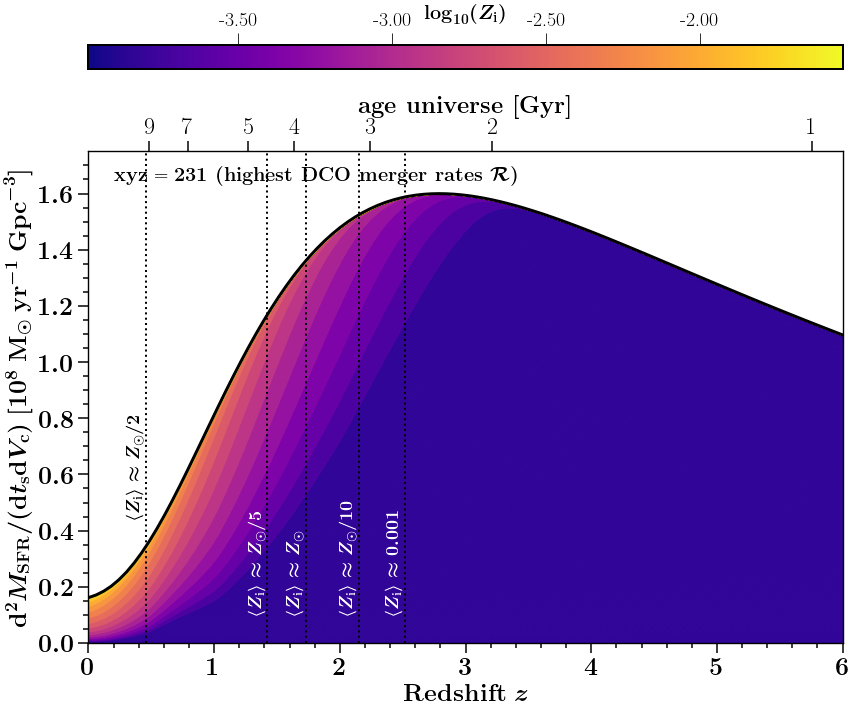

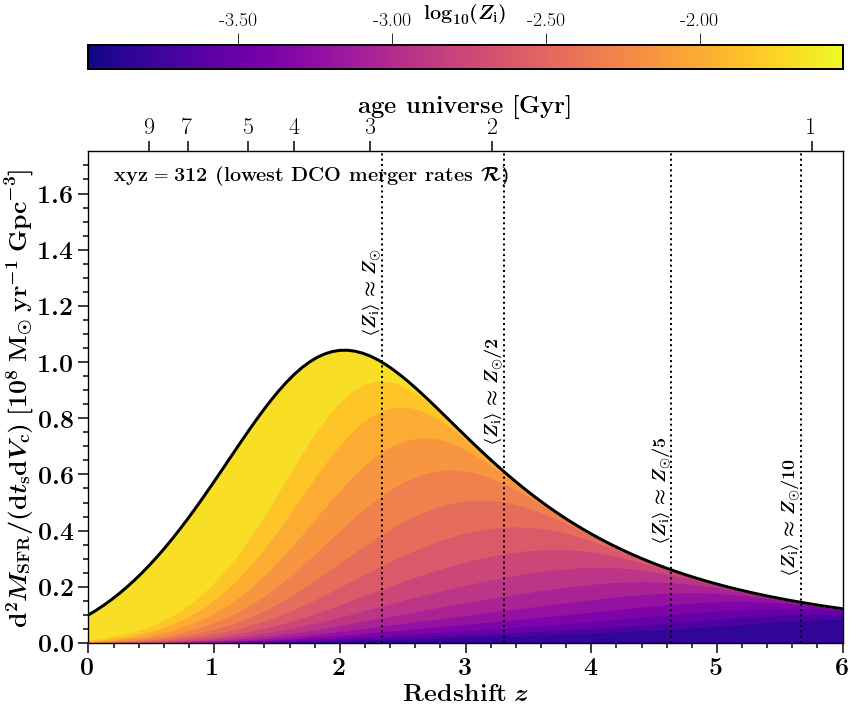

In [2]:
metallicityGrid = np.logspace(-4, -1.5,100)
mssfr = ClassMSSFR.MSSFR(metallicityGrid=metallicityGrid)



#.            FIDUCIAL                    HIGHEST.                        LOWEST 
method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'] #                      
SFRs       = ['Neijssel et al. (2019)'   ,'Strolger et al. (2004)'         ,'Madau & Fragos (2017)']#         
logNormal  = ['Neijssel Phenomenological', None                         , None                  ]#   
GSMFs      = [None                       ,'Furlong et al. (2015) Double', 'Panter et al. (2004) Single']#
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. +offset (2006)'        ]#

linestyles = ['-'                        , '--'                         , ':'                           ]#
labels     = ['000 (Neijssel+19, fiducial model)'                 , r'231 (highest DCO merger rates $\mathcal{R}$)'              , '312 (lowest DCO merger rates $\mathcal{R}$)']#
labelsSafeFig = ['_xyz000_', '_xyz231_', '_xyz312_']

cm       = plt.get_cmap('viridis')
nColors  = 8+1  #want three colours for three variations (1 used in other plot later)
                    # dont want the brigthest colour hence I add a dummy value.
                    #Should be consistent with figure of metallicity PDFs
mycolors = [cm(x) for x in np.linspace(0,1 , nColors)]

colours  =  [ 'b'                        ,mycolors[0]                   , mycolors[1]       \
             , mycolors[2], mycolors[3]]

solar=0.0142

# redshifts = [0, 1, 2, 3, 4, 5, 6, 7]
# zcolors       = sns.color_palette("husl", len(redshifts))
# redshifts         = [0, 2, 4]
# labelsZ = [r'$z=0 $',r'$z=1$', r'$z=2$']
alphas = [1.0, 0.6, 0.3]

# redshifts=[0,1,2,3]
zcolors       = sns.color_palette("husl", 7)


zRedshiftBins = np.linspace(0,6, 100)
zRedshiftCenter = (zRedshiftBins[1:] + zRedshiftBins[:-1])/2.
widthzRedshift = np.diff(np.log10(zRedshiftBins))

for fixedIndex in [0,1,2]:

    fig, axe = plt.subplots(4,1, figsize=(12,10),\
                           gridspec_kw={"height_ratios":1*np.concatenate(([0.1,0.15, 0.5], 3*np.ones(1)))})
    axes=axe[3]

    zBins = (np.logspace(-10, np.log10(0.5), 100))
    center = (zBins[1:] + zBins[:-1])/2.
    width  = np.diff(np.log10(zBins))
    # Zcolors =  sns.color_palette("plasma", len(Zgrid))
    maskBelow = (zBins <0.001)
    maskAbove = (zBins > 0.03)
    Nbelow = int(sum(maskBelow))
    Nabove = int(sum(maskAbove))
    NinRange = len(zBins) - Nbelow - Nabove

    zMetallicitycolors_       = sns.color_palette("plasma", NinRange)

    zMetallicitycolors = []
    for ll in range(Nbelow):
        zMetallicitycolors.append(zMetallicitycolors_[0]) 


    for ll in range(NinRange):    
        zMetallicitycolors.append(zMetallicitycolors_[ll])
    for ll in range(Nabove):
        zMetallicitycolors.append(zMetallicitycolors_[-1]) 


    handles1 = []



    weightedMetallicity = np.zeros_like(zRedshiftBins)
    normalisation_wMetallicity = np.zeros_like(zRedshiftBins)


    ybottom = np.zeros_like(zRedshiftBins)
    for nrZ, Z in enumerate(center):
        Zlower   = zBins[nrZ]
        Zupper   = zBins[nrZ+1]

        for nrL, L in enumerate([labels[fixedIndex]]):
            nrL=fixedIndex
            PDF = np.zeros(len(zRedshiftBins))
            mssfr.Zprescription         = method[nrL]
            mssfr.SFRprescription       = SFRs[nrL]
            mssfr.logNormalPrescription = logNormal[nrL]
            mssfr.GSMFprescription      = GSMFs[nrL]
            mssfr.ZMprescription        = MZs[nrL]
            #code is done such that we have to do it per metallicity
            for nrz, redshift in enumerate(zRedshiftBins):

                if method[nrL] == 'logNormal':
                    PDF[nrz] = mssfr.returnFractionLogNormal(Zlower, Zupper, redshift) * mssfr.SFR_Neijssel(redshift)
                if method[nrL] == 'MZ_GSMF':

                    if nrL==1:
                        agex      = mssfr.cosmology.age(redshift).value
                        PDF[nrz] = mssfr.returnFractionMZ_GSMF(Zlower, Zupper, [redshift])* mssfr.SFR_Strolger(agex)
                    elif nrL==2:
                        PDF[nrz] = mssfr.returnFractionMZ_GSMF(Zlower, Zupper, [redshift])* mssfr.SFR_Madau2(redshift)

            weightedMetallicity += Z*PDF
            normalisation_wMetallicity += PDF 

            if nrL==0:
                label = False #r'$z=%s$'%redshift #labelsZ[nrz]  #+'  '+'  z='+str(redshift[0])
                ll    = True
            else:
                label = None
                ll    = False

            axes.fill_between(zRedshiftBins, ybottom,  ybottom+(PDF/1E8),  color=zMetallicitycolors[nrZ], \
                  label=label, alpha=1,  zorder=2)
            ybottom += PDF / 1E8

    axes.plot(zRedshiftBins, ybottom, color='k', lw=3, zorder=4)


    top_y=1.75

    # axes layout
    nameX = r'\textbf{Redshift} $z$'
    nameY = r'$ {\rm{d}}^2M_{\rm{SFR}}/({\rm{d}}t_{{\rm{s}}}{\rm{d}}V_{\rm{c}}) \   [10^8\ {\rm{M}}_{\odot}\  {\rm{yr}}^{-1}\ {\rm{Gpc}}^{-3}]$'



    axes = layoutAxes(axes, nameX=nameX, nameY=nameY)
    axes.set_ylim(bottom=0, top=top_y)
    axes.set_xlim(0,6)

    averageZ_perRedshift = weightedMetallicity / normalisation_wMetallicity

    ################# SECOND X-AXIS with AGE #################
    axes2  = axes.twiny()
    # second x-axis for age
    nameX2 = r'\textbf{age universe [Gyr]}'
    # axes2.xaxis.labelpad = 20
    axes2.set_xlabel(nameX2, fontsize=fs+4)
    axes2.tick_params(labelsize=fs+4)
    layoutAxes(axes2, nameX=nameX2, nameY=None, fontsize=fs+4, second=False, labelpad=None, setMinor=False)
    axes2.set_xlim(0,6)


    redshifts = np.linspace(0,6,100)
    #strolger works in age not redshift
    ages      = mssfr.cosmology.age(redshifts).value
    #find nearest redshift to age
    agelabels = np.array([1,2,3,4,5,7, 9]) #Gyr
    ageUniverse = mssfr.cosmology.age(0)
    redshiftTicks = np.zeros(len(agelabels))
    for nr, age in enumerate(agelabels):
        distance = np.abs(ages-age)
        ind      = np.where(distance==np.min(distance))[0][0]
        redshiftTicks[nr] =  redshifts[ind]

    axes2.set_xticks(redshiftTicks)
    axes2.set_xticklabels(agelabels)
    # second x-axis for age
    nameX2 = r'\textbf{age universe [Gyr]}'
    # axes2.xaxis.labelpad = 20
    axes2.set_xlabel(nameX2, fontsize=fs+4)
    axes2.tick_params(labelsize=fs+4)
    layoutAxes(axes2, nameX=nameX2, nameY=None, fontsize=fs+4, setMinor=False)
    axes2.set_xlim(0,6)
    ##################################################



    axes.text(0.2, 1.7, r'$\textbf{xyz}$ = \textbf{%s}'%labels[nrL], fontsize = fs, color ='k', ha = 'left', va='top')

    ############ COLOR BAR ###########
    zBins = (np.logspace(-4, np.log10(0.03), 100))
    center = (zBins[1:] + zBins[:-1])/2.
    width  = np.diff(np.log10(zBins))
    xx = center
    # nonvalues = xx-100

    axe[0].axis('off')
    axe[2].axis('off')
    cm = plt.cm.get_cmap('plasma')
    sc = axe[3].scatter(np.log10(xx), np.log10(xx), c=np.log10(xx), vmin=min(np.log10(center)), vmax=max(np.log10(center)), s=35, cmap=cm)
    cbar = fig.colorbar(sc, cax=axe[1], orientation='horizontal' , format="%.2f")#, boundaries=np.logspace(np.log10(min(center)),max(np.log10(center)),5))#orientation="horizontal", pad=0.2)
    cbar.ax.tick_params(labelsize=20, labeltop=True, labelbottom=False, bottom=False, top=True)
    axe[0].set_title(label=r'$\log_{10}(Z_{\rm{i}})$', size=20)
    #################################




    ######### make av Metallicity lines ##########

    for ind_avZi, avZi in enumerate(averageZ_perRedshift):
        if avZi >= solar:
            ind_solar = ind_avZi
        if avZi >= solar/2.:
            ind_0_5solar = ind_avZi
        if avZi >= solar/5.:
            ind_0_2solar = ind_avZi    
        if avZi >= solar/10.:
            ind_0_1solar = ind_avZi   
        if avZi >= 0.001:
            ind_0_001 = ind_avZi   
    text_list = [r'$\langle Z_{\rm{i}} \rangle \approx Z_{\odot}$', \
                 r'$\langle Z_{\rm{i}} \rangle \approx Z_{\odot}/2$', \
                 r'$\langle Z_{\rm{i}} \rangle \approx Z_{\odot}/5$', \
                 r'$\langle Z_{\rm{i}} \rangle \approx Z_{\odot}/10$',\
                 r'$\langle Z_{\rm{i}} \rangle \approx 0.001$'] 
    for nr_i, ind_ in enumerate([ind_solar, ind_0_5solar, ind_0_2solar, ind_0_1solar, ind_0_001]): 
        if ind_<99:
            xx = zRedshiftCenter[ind_]
            yy_text = (normalisation_wMetallicity[ind_] + normalisation_wMetallicity[ind_+1] ) / 2
            yy_text/=1E8
            if yy_text>= 1.1:
                axes.text(x=xx, y=0.1, s=text_list[nr_i], fontsize=18, rotation=90, va='bottom', ha='right', color='white')

            else:
                axes.text(x=xx, y=yy_text+0.1, s=text_list[nr_i], fontsize=18, rotation=90, va='bottom', ha='right')

            axes.plot([xx,xx], [0,top_y], lw=2, linestyle=':', c='k')



    #################################


    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('./SFRDandZi'+labelsSafeFig[nrL]+'.png', dpi=600, bbox_inches='tight')
    plt.savefig('./SFRDandZi'+labelsSafeFig[nrL]+'.pdf',bbox_inches='tight')
    plt.show()
    plt.close()